In [ ]:
%load_ext autoreload
%autoreload 2

import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from lalinference import BurstSineGaussian
from ripplegw.waveforms import SineGaussian

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

params = {
    "text.usetex" : True,
    "font.family" : "serif",
    "ytick.color" : "black",
    "xtick.color" : "black",
    "axes.labelcolor" : "black",
    "axes.edgecolor" : "black",
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.labelsize": 16,
    "legend.fontsize": 16,
    "legend.title_fontsize": 16,
    "figure.titlesize": 16
}

plt.rcParams.update(params)

In [2]:
def vary_parameters(
    quality, frequency, hrss, phase, eccentricity, duration = 10.0, fs=4096, delta_t=1 / 4096
):
    """Helper function to generate sine-gaussian waveforms with varying parameters."""
    hcross, hplus = SineGaussian.gen_SineGaussian(quality, frequency, hrss, phase, eccentricity, duration, fs)
    hcross_lal, hplus_lal, hcross_ripple, hplus_ripple, diff_hcross, diff_hplus = [], [], [], [], [], []
    length = max(len(quality), len(frequency), len(hrss), len(phase), len(eccentricity))
    
    for i in range(length):
        hplus_, hcross_ = BurstSineGaussian(
            Q=quality[i].item(),
            centre_frequency=frequency[i].item(),
            hrss=hrss[i].item(),
            eccentricity=eccentricity[i].item(),
            phase=phase[i].item(),
            delta_t=delta_t,
        )
        hplus_ = hplus_.data.data
        hcross_ = hcross_.data.data
        n_samples = len(hplus_)
        start, stop = (
            len(hcross[i]) // 2 - n_samples // 2,
            len(hcross[i]) // 2 + n_samples // 2 + 1,
        )
        hcross_ripple.append(hcross[i][start:stop])
        hplus_ripple.append(hplus[i][start:stop])
        hcross_lal.append(hcross_)
        hplus_lal.append(hplus_)
        diff_hcross.append(hcross_ripple[i] - hcross_lal[i])
        diff_hplus.append(hplus_ripple[i] - hplus_lal[i])
    max_diff_hcross = jnp.array([jnp.max(jnp.abs(diff_hcross[i])) for i in range(length)])
    max_diff_hplus = jnp.array([jnp.max(jnp.abs(diff_hplus[i])) for i in range(length)])
    return hcross_lal, hplus_lal, hcross_ripple, hplus_ripple, diff_hcross, diff_hplus, max_diff_hcross, max_diff_hplus

### Generate waveforms by varying all parameters at once

In [3]:
quality = jnp.linspace(3, 100, 100)
frequency = jnp.logspace(1, 3, 100)
hrss = jnp.logspace(-23, -6, 100)
phase = jnp.linspace(0, 2 * np.pi, 100)
eccentricity = jnp.linspace(0, 0.99, 100)

hcross_lal, hplus_lal, hcross_ripple, hplus_ripple, \
diff_hcross, diff_hplus, max_diff_hcross, \
max_diff_hplus = vary_parameters(
    quality, frequency, hrss, phase, eccentricity
)

### Plot a comparision

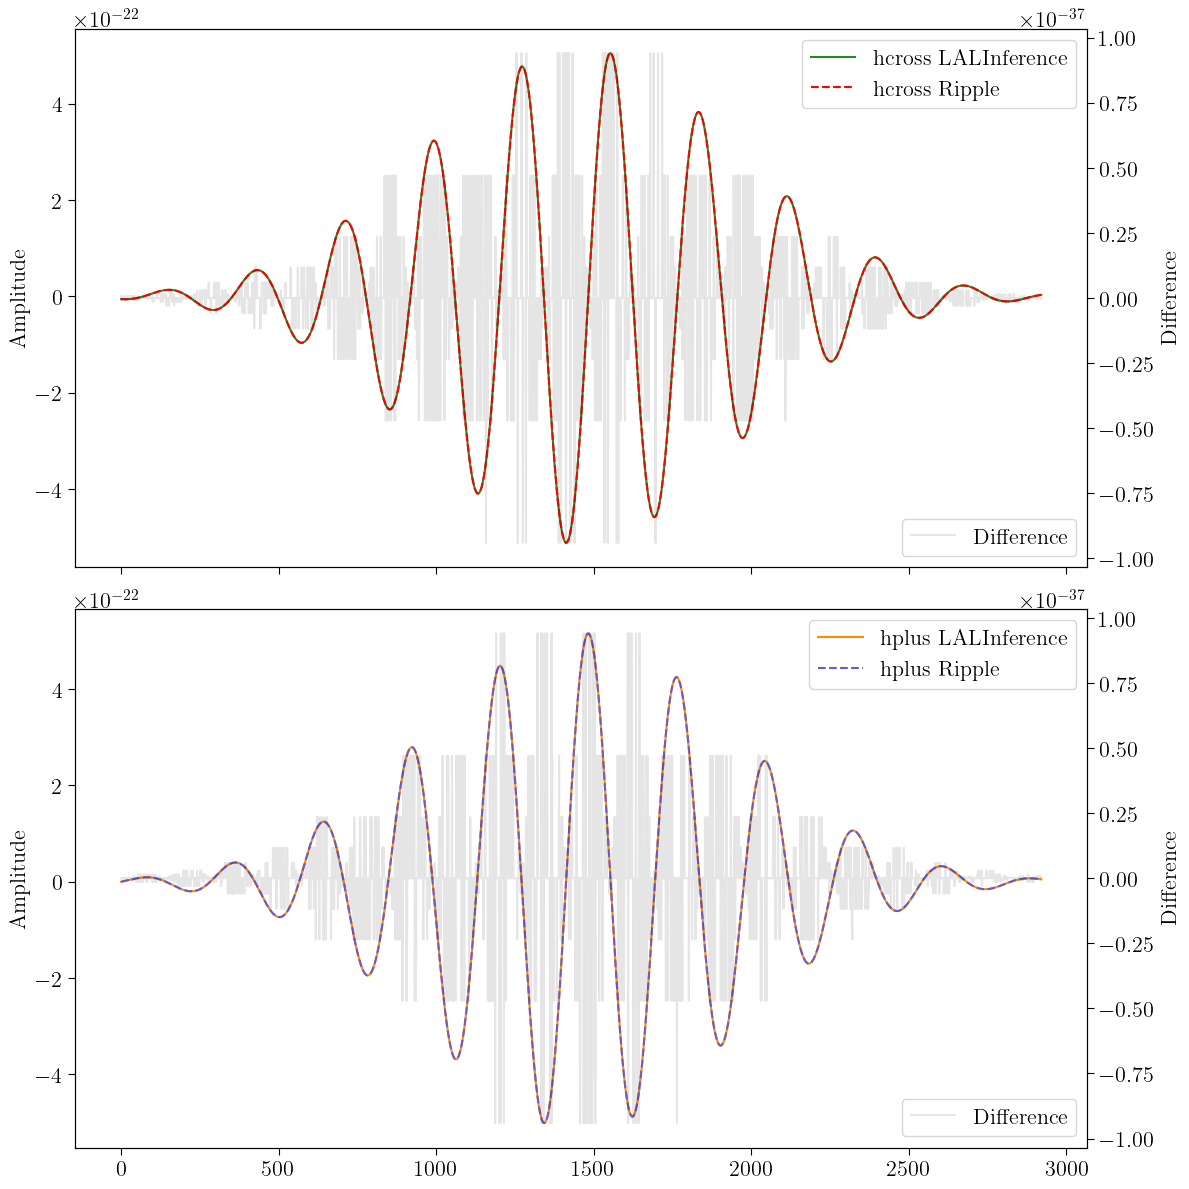

Max difference in hcross: 9.4039548065783e-38
Max difference in hplus: 9.4039548065783e-38
Paraqmeters:
    quality=10.838, frequency=14.508, hrss=2.364489412645407e-22, phase=0.508, eccentricity=0.080


In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# choose a random waveform
i = np.random.randint(0, 10)

# subplot for hcross
ax1_ = ax1.twinx()
ax1_.plot(diff_hcross[i], label="Difference", color="black", alpha=0.1)
ax1.plot(hcross_lal[i], label="hcross LALInference", linestyle="-", color="forestgreen")
ax1.plot(hcross_ripple[i], label="hcross Ripple", linestyle="--", color="red")
ax1.set_ylabel("Amplitude")
ax1_.set_ylabel("Difference")
max_diff = np.max(np.abs(max_diff_hcross[i]))
ax1_.set_ylim(-1.1*max_diff, 1.1*max_diff)
ax1.legend(loc="upper right")
ax1_.legend(loc="lower right")

# subplot for hplus
ax2_ = ax2.twinx()
ax2_.plot(diff_hplus[i], label="Difference", color="black", alpha=0.1)
ax2.plot(hplus_lal[i], label="hplus LALInference", linestyle="-", color="darkorange")
ax2.plot(hplus_ripple[i], label="hplus Ripple", linestyle="--", color="slateblue")
ax2.set_ylabel("Amplitude")
ax2_.set_ylabel("Difference")
max_diff = np.max(np.abs(max_diff_hplus[i]))
ax2_.set_ylim(-1.1*max_diff, 1.1*max_diff)
ax2.legend(loc="upper right")
ax2_.legend(loc="lower right")
fig.tight_layout()
plt.show()

print(f"Max difference in hcross: {max_diff_hcross[i]}\nMax difference in hplus: {max_diff_hplus[i]}\nParaqmeters:\n\
    quality={quality[i].item():.3f}, frequency={frequency[i].item():.3f}, hrss={hrss[i].item()}, phase={phase[i].item():.3f}, eccentricity={eccentricity[i].item():.3f}")

### Vary each parameter independently by fixing others

The constant values of other parameters were chosen to be somewhere in the middle of the range, except for the hrss value which was chosen just slightly lower than value that crosses the noise floor

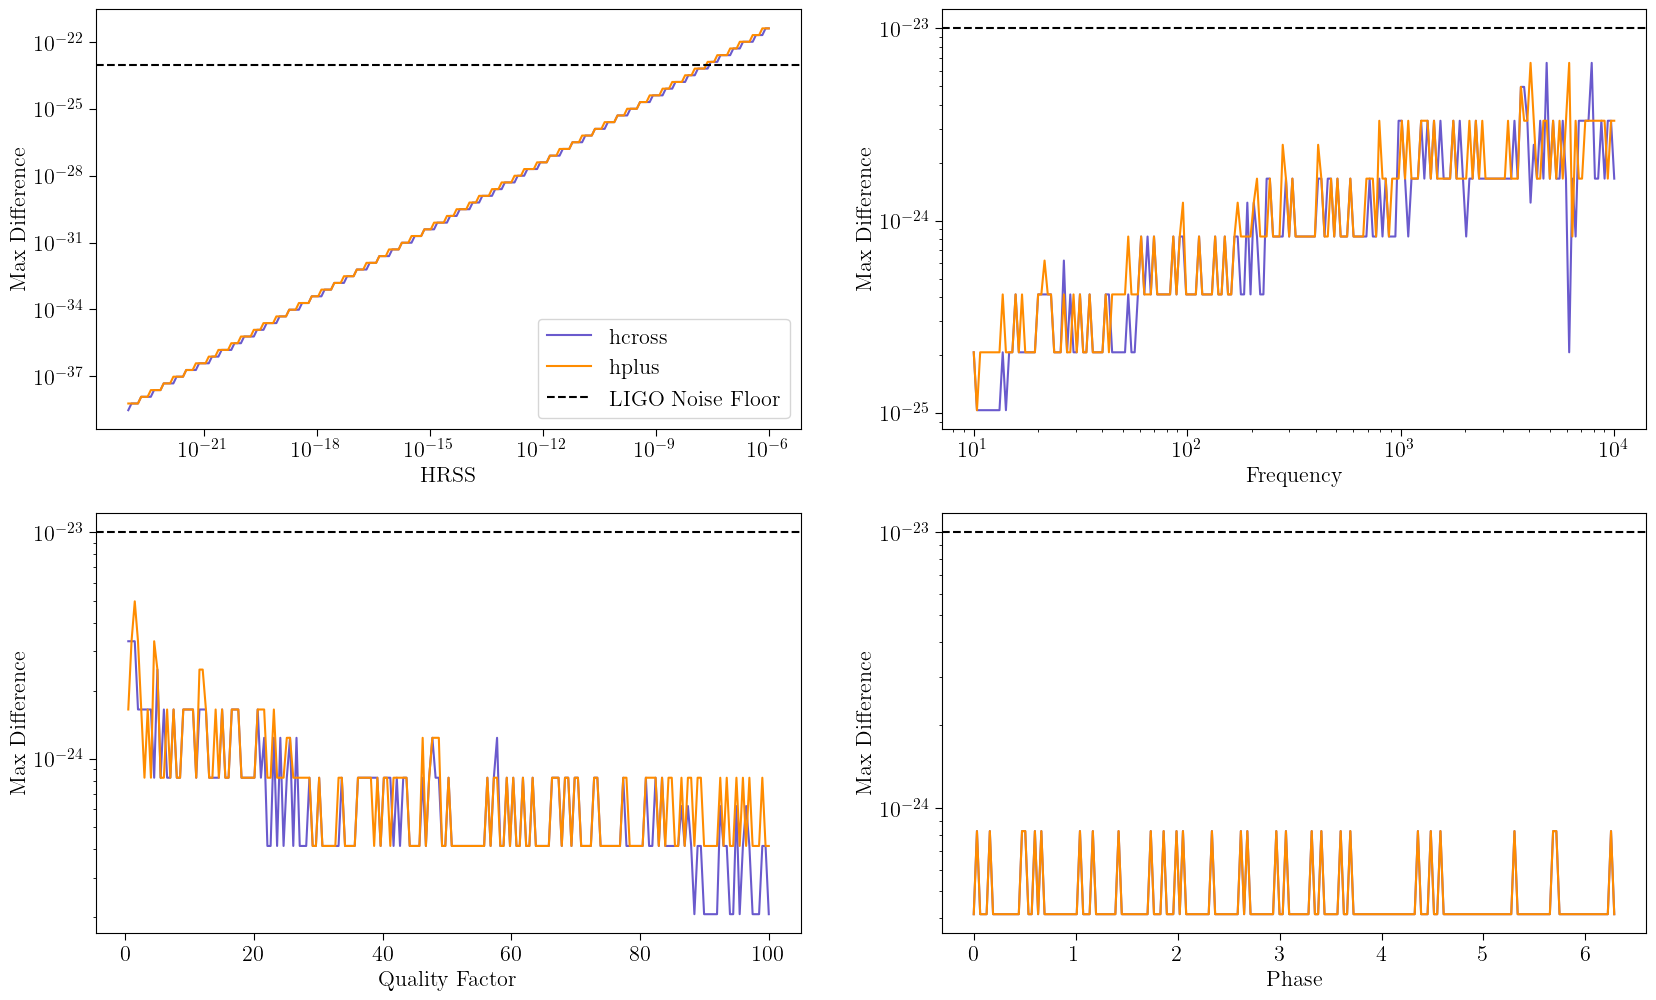

In [5]:
N = 200
LIGO_NOISE_FLOOR = 1e-23 # https://www.ligo.org/science/Publication-O1Noise/Images/IFO_STRAIN.png


quality, frequency, hrss, phase, eccentricity = 50*jnp.ones(N), 100*jnp.ones(N), \
    jnp.logspace(-23, -6, N), jnp.pi*jnp.ones(N), 0.5*jnp.ones(N)
*_, max_diff_hcross, max_diff_hplus = vary_parameters(
    quality, frequency, hrss, phase, eccentricity
)


fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax[0, 0].plot(hrss, max_diff_hcross, label="hcross", color="slateblue")
ax[0, 0].plot(hrss, max_diff_hplus, label="hplus", color="darkorange")
ax[0, 0].axhline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
ax[0, 0].set_xscale("log")
ax[0, 0].set_yscale("log")
ax[0, 0].set_xlabel("HRSS")
ax[0, 0].set_ylabel("Max Difference")
ax[0, 0].legend()

quality, frequency, hrss, phase, eccentricity = 50*jnp.ones(N), jnp.logspace(1, 4, N), \
    1e-9*jnp.ones(N), jnp.pi*jnp.ones(N), 0.5*jnp.ones(N)
*_, max_diff_hcross, max_diff_hplus = vary_parameters(
    quality, frequency, hrss, phase, eccentricity
)

ax[0, 1].plot(frequency, max_diff_hcross, label="hcross", color="slateblue")
ax[0, 1].plot(frequency, max_diff_hplus, label="hplus", color="darkorange")
ax[0, 1].axhline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
ax[0, 1].set_xscale("log")
ax[0, 1].set_yscale("log")
ax[0, 1].set_xlabel("Frequency")
ax[0, 1].set_ylabel("Max Difference")

quality, frequency, hrss, phase, eccentricity = jnp.linspace(0, 100, N), 100*jnp.ones(N), \
    1e-9*jnp.ones(N), jnp.pi*jnp.ones(N), 0.5*jnp.ones(N)
*_, max_diff_hcross, max_diff_hplus = vary_parameters(
    quality, frequency, hrss, phase, eccentricity
)


ax[1, 0].plot(quality, max_diff_hcross, label="hcross", color="slateblue")
ax[1, 0].plot(quality, max_diff_hplus, label="hplus", color="darkorange")
ax[1, 0].axhline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
ax[1, 0].set_yscale("log")
ax[1, 0].set_xlabel("Quality Factor")
ax[1, 0].set_ylabel("Max Difference")


quality, frequency, hrss, phase, eccentricity = 50*jnp.ones(N), 100*jnp.ones(N), \
    1e-9*jnp.ones(N), jnp.linspace(0, 2*jnp.pi, N), 0.5*jnp.ones(N)
*_, max_diff_hcross, max_diff_hplus = vary_parameters(
    quality, frequency, hrss, phase, eccentricity
)

ax[1, 1].plot(phase, max_diff_hcross, label="hcross", color="slateblue")
ax[1, 1].plot(phase, max_diff_hplus, label="hplus", color="darkorange")
ax[1, 1].axhline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
ax[1, 1].set_yscale("log")
ax[1, 1].set_xlabel("Phase")
ax[1, 1].set_ylabel("Max Difference")

plt.show()

### Pairwise comparsions

In [29]:
quality = jnp.array(np.linspace(3, 100, 10))
frequency = jnp.array(np.logspace(1, 3, 100))
hrss = jnp.array(np.logspace(-15, -6, 100))
phase = jnp.pi*jnp.ones(100000)
eccentricity = 0.5*jnp.ones(100000)

# generate paramter space
quality, frequency, hrss = jnp.meshgrid(quality, frequency, hrss)
quality, frequency, hrss = quality.flatten(), frequency.flatten(), hrss.flatten()

max_diff_hcross, max_diff_hplus = [], []

for i in range(100):
    *_, max_diff_hcross_, max_diff_hplus_ = vary_parameters(
        quality[i*1000: (i+1)*1000], frequency[i*1000: (i+1)*1000], hrss[i*1000: (i+1)*1000], phase[i*1000: (i+1)*1000], eccentricity[i*1000: (i+1)*1000]
    )
    for j in range(1000):
        max_diff_hcross.append(max_diff_hcross_[j])
        max_diff_hplus.append(max_diff_hplus_[j])

max_diff_hcross, max_diff_hplus = np.array(max_diff_hcross), np.array(max_diff_hplus)

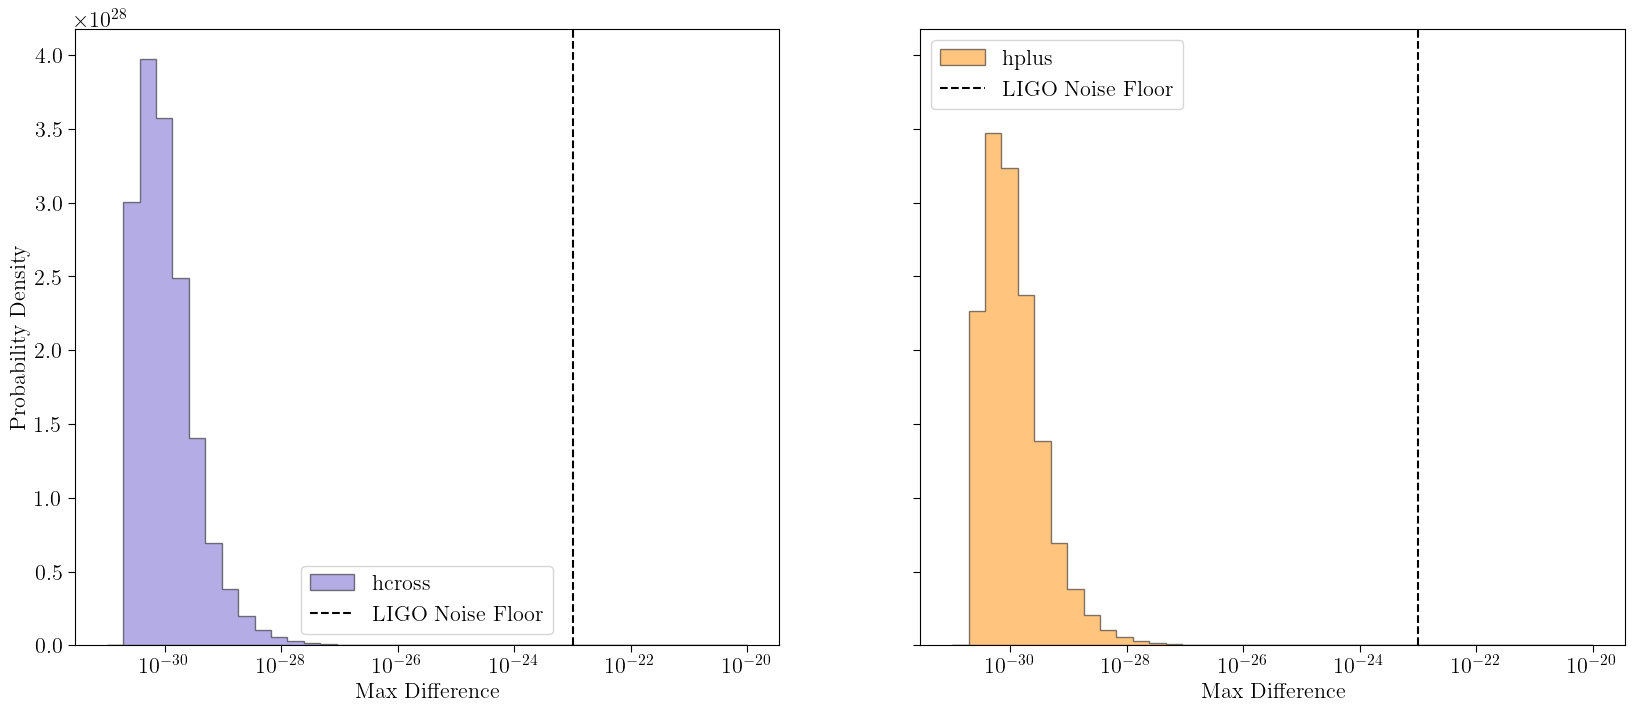

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

min_exp = int(np.log10(np.min(max_diff_hcross[max_diff_hcross>0])))
max_exp = int(np.log10(np.max(max_diff_hcross)))

ax[0].hist(max_diff_hcross, bins=np.logspace(min_exp, max_exp, 40), alpha=0.5, label="hcross", color="slateblue", density=True, histtype="stepfilled", edgecolor="black")
ax[0].axvline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
ax[0].set_xscale("log")
ax[0].set_xlabel("Max Difference")
ax[0].set_ylabel("Probability Density")
ax[0].legend()

min_exp = int(np.log10(np.min(max_diff_hplus[max_diff_hplus>0])))
max_exp = int(np.log10(np.max(max_diff_hplus)))

ax[1].hist(max_diff_hplus, bins=np.logspace(min_exp, max_exp, 40), alpha=0.5, label="hplus", color="darkorange", density=True, histtype="stepfilled", edgecolor="black")
ax[1].axvline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
ax[1].set_xscale("log")
ax[1].set_xlabel("Max Difference")
ax[1].legend()

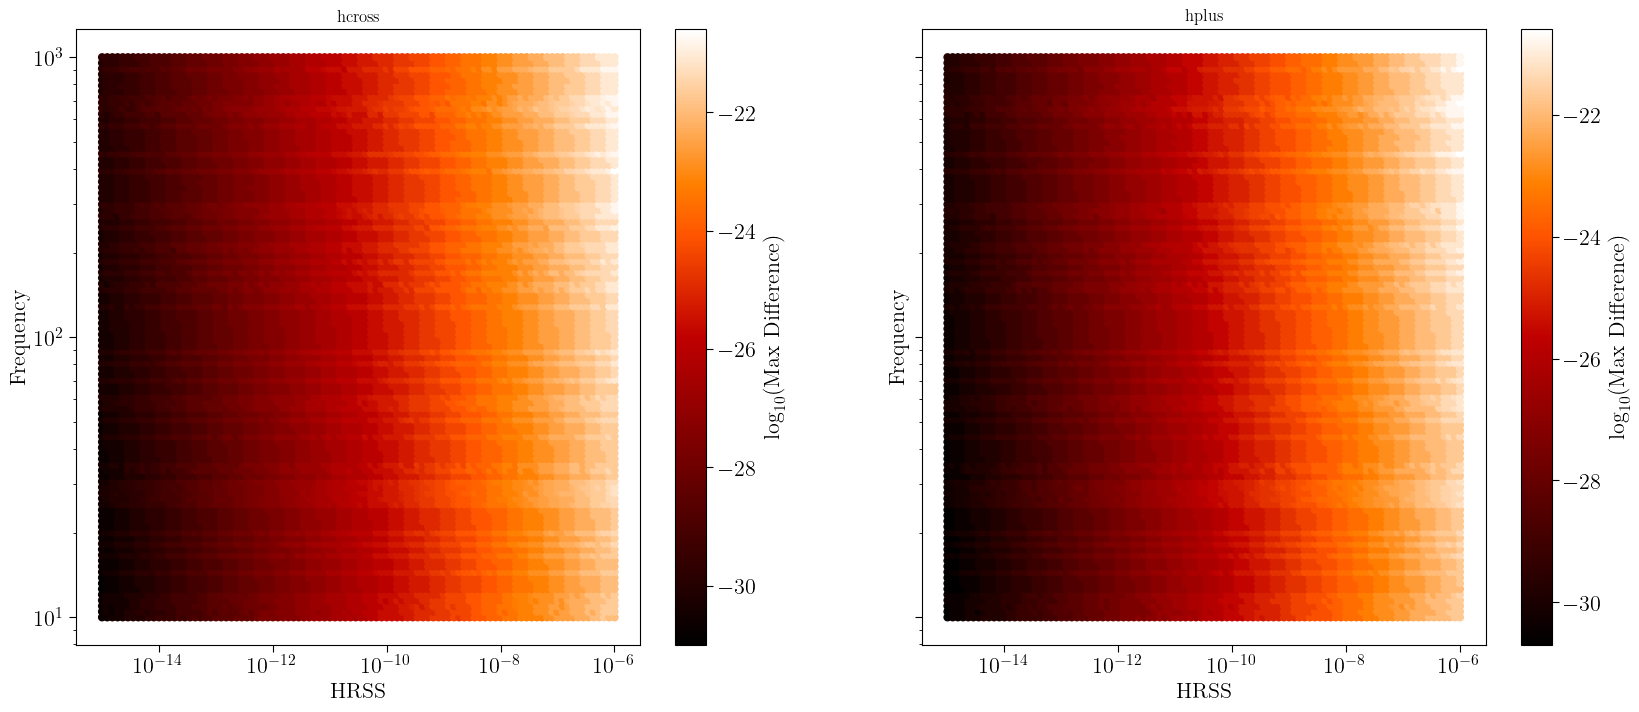

In [48]:
mask = np.where(quality == np.sort([*set(np.array(quality))])[5])
frequency_ = frequency[mask]
hrss_ = hrss[mask]
max_diff_hcross_ = max_diff_hcross[mask]
max_diff_hplus_ = max_diff_hplus[mask]

fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

scatter = ax[0].scatter(hrss_, frequency_, c=np.log10(max_diff_hcross_), cmap="gist_heat", s=25)
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel("HRSS")
ax[0].set_ylabel("Frequency")
ax[0].set_title("hcross")
fig.colorbar(scatter, ax=ax[0], label=r"$\log_{10}$(Max Difference)")


scatter = ax[1].scatter(hrss_, frequency_, c=np.log10(max_diff_hplus_), cmap="gist_heat", s=25)
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlabel("HRSS")
ax[1].set_ylabel("Frequency")
ax[1].set_title("hplus")
fig.colorbar(scatter, ax=ax[1], label=r"$\log_{10}$(Max Difference)")

plt.show()